In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Вспомогательные функции

In [2]:
def func(x, t):
    """
    f(x,t,u) в исходном уравнении
    """
    return - np.exp( np.sin(x) * np.cos(t) ) + np.sin(x) * np.cos(t)


def psi(u):
    """
    Нелиненая функция, определяющая нелинейность дифференциального оператора
    """
    return np.exp(u)

def psi_der(u):
    return np.exp(u)


def mu(t):
    """
    Граничные условия
    """
    return 0
    
    
def phi(x):
    """
    Начальные условия
    """
    return np.sin(x)


def init(N, T, h, delta):
    """
    Задание начальных и граничных условий
    """
    x = np.array([i * h for i in range(N + 1)])
    t = np.array([j * delta for j in range(T + 1)])
    U = np.zeros(shape=(N + 1, T + 1))
    U[:, 0] = phi(x)
    U[0, :] = mu(t.T)
    U[-1, :] = mu(t.T)
    return x, t, U


def real(x, t):
    """
    Форма точного решения
    """
    return np.sin(x) * np.cos(t)


def exact(h, delta):
    """
    Точное решение
    """
    N = int(np.pi / h)
    T = int(8 / delta)
    x, t, _ = init(N, T, h, delta)
    U_real = np.zeros(shape=(N + 1, T + 1))
    for j in range(T + 1):
        for i in range(N + 1):
            U_real[i, j] = real(x[i], t[j])
    return x, t, U_real

#### Представление результата

In [3]:
def plot(t, x, U, title):    
    """
    Построение графика U(x, t)
    """
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    T, X = np.meshgrid(t, x)
    Z = U.T
    ax.plot_surface(T, X, Z, cmap="viridis", rstride=1, cstride=1, linewidth=0)    
    ax.view_init(30, 220);
    plt.suptitle(title)
    plt.show()

    
def error_max(U, h, delta):
    """
    Вычисление ошибки
    """
    x, t, U_real = exact(h, delta)
    return np.max(np.abs(U - U_real))


def error_shape(U, h, delta):
    """
    Нахождение формы ошибки
    """
    x, t, U_real = exact(h, delta)
    return np.abs(U - U_real)


def result(schema, title):
    """
    Сравнение результатов для разных 
    разбиений по x и t
    """
    _errors = []
    _steps = []
    _deltas = []
    steps = [np.pi / 5, np.pi / 10, np.pi / 20]
    deltas = [0.25, 0.10, 0.05]
    
    x, t, U = schema(steps[0], deltas[0])
    plot(x, t, U, title)
    plot(x, t, error_shape(U, steps[0], deltas[0]), title + "_error")
    
    for h in steps:
        for delta in deltas:
            x, t, U = schema(h, delta)
            err = error_max(U, h, delta)
            _errors.append(err)
            _steps.append(h)
            _deltas.append(delta)

    df = pd.DataFrame(data={
        "step": _steps, 
        "delta": _deltas,
        "error": _errors
    })
    return df


def not_good_enough(guess, x, eps):
    error = np.linalg.norm(guess - x)
    if(error > eps):
        return True, error
    return False, error

### Точное решение

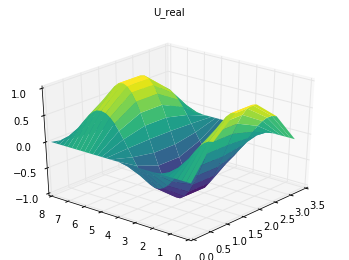

In [4]:
delta, h = 0.25, np.pi / 5
x, t, U_real = exact(h, delta)
plot(x, t, U_real, title="U_real")

### Схема Кранка-Никольсон

In [5]:
def crank_nickolson(h, delta):
    """
    Схема Кранка-Никольсон с решением по методу Ньютона
    """
    
    eps = 10 ** (- 5)
    N = int(np.pi / h)
    T = int(8 / delta)
    gamma = delta / (h ** 2)
    x, t, U = init(N, T, h, delta)
    
    for j in range(T):
        
        temp = np.zeros(shape=(N - 1,))
        _temp = np.zeros(shape=(N - 1,))
        F = np.zeros(shape=(N - 1,))
        W = np.zeros(shape=(N - 1, N - 1))
        
        flag = True
        n_step = 0
        
        while flag:

            # Решаем уравнение F(U) = 0, где U - искомый вектор на (j+1) временном слое
            # На каждой k итерации ищем F(U_{k-1}) и матрицу Якоби W(U_{k-1})
            # и делаем следующий шаг U_{k} = U_{k-1} - W_inv(U_{k-1}) * F(U_{k-1}) до сходимости

            for i in range(1, N - 2):
                het = psi(U[i + 1, j]) + gamma * (U[i, j] - 2 * U[i + 1, j] + U[i + 2, j]) + delta * func(x[i + 1], t[j + 1])
                F[i] = psi(temp[i]) - gamma * (temp[i - 1] - 2 * temp[i] + temp[i + 1]) - het
                
                W[i, i - 1] = - gamma
                W[i, i] = psi_der(temp[i]) + 2 * gamma
                W[i, i + 1] = - gamma
                
            F[0] = (
                    psi(temp[0]) - gamma * (U[0, j] - 2 * temp[0] + temp[1]) - \
                    psi(temp[0]) - gamma * (U[0, j] - 2 * temp[0] + temp[1]) - delta * func(x[1], t[j + 1])
            )
            
            F[N - 2] = (
                    psi(temp[N - 2]) - gamma * (temp[N - 3] - 2 * temp[N - 2] + U[N, j]) - \
                    psi(temp[N - 2]) - gamma * (temp[N - 3] - 2 * temp[N - 2] + U[N, j]) - delta * func(x[N - 1], t[j + 1])
            )
                

            W[0, 0] = psi_der(U[0, j]) + 2 * gamma
            W[0, 1] = - gamma
            W[N - 2, N - 2] = psi_der(U[N, j]) + 2 * gamma
            W[N - 2, N - 3] = - gamma
      
            W_rev = np.linalg.inv(W)
            temp = temp - np.dot(W_rev, F)

            flag, error = not_good_enough(temp, _temp, eps)
            _temp = temp  
   
            n_step += 1
#             print("Step : {0}, Error : {1}".format(n_step, error))
        
        U[1:N, j + 1] = temp
           
        
    return x, t, U

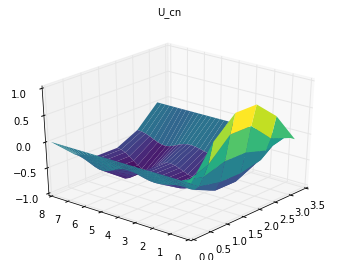

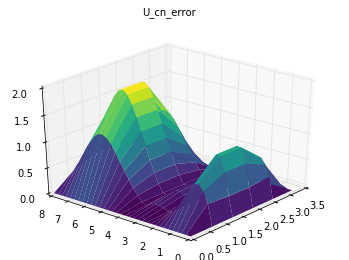

,delta,error,step
0,0.25,1.828025,0.628319
1,0.10,1.824599,0.628319
2,0.05,1.823898,0.628319
3,0.25,1.902836,0.314159
4,0.10,1.897858,0.314159
5,0.05,1.897423,0.314159
6,0.25,1.899018,0.157080
7,0.10,1.894008,0.157080
8,0.05,1.893624,0.157080


In [6]:
result(crank_nickolson, "U_cn")